# 🎗️[Baseline Model] RSNA Breast Cancer
---

In [376]:
import os 

# Data manipulation libraries
import pandas as pd
import numpy as np

# Data visualization libraries
import matplotlib.pyplot as plt

# Random seed generator
import random 

# Tensorflow libraries
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import Model
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Activation, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# OpenCV library
import cv2

# Sklearn libraries
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

# Kaggle libraries
from kaggle_datasets import KaggleDatasets

# Custom augmentation layers
from tensorflow.keras.layers import RandomZoom, RandomRotation, RandomTranslation

# IPython display library
from IPython.display import clear_output

# Configuration

In [361]:
class CFG:
    # General information
    competition = 'rsna-bcd'
    dataset = 'rsna-preprocessed-512x256'
    model_name = 'EfficientNetV1B4'
    attempt = 0
    
    # Device information
    device = 'TPU-1VM'
    mixed_precision = False # faster but less accurate
    
    # Target name
    labels = 'cancer'
    
    # Reproducibility
    seed = 42
    
    # Display options
    verbose = 1
    display_plot = True
    
    # Image and batch size information
    img_size = (512, 256)
    batch_size = 32
    epochs = 8
    
    # Loss function options
    loss = 'Focal' # Can also be set to 'BCE'
    use_cw = False
    
    # Optimizer
    optimizer = 'Adam'
    
    # Augmentation options
    augment = True
    augment_prob = 0.9
    fill_mode = 'constant'
    zoom = 0.25
    rot = 3 # in degrees
    hshift = 0.05
    wshift = 0.05

# Device Configuration

In [215]:
if 'TPU' in CFG.device:
    tpu = 'local' if CFG.device=='TPU-1VM' else None
    print("Connecting to TPU...")
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect(tpu=tpu)
        strategy = tf.distribute.TPUStrategy(tpu)
    except:
        CFG.device = 'GPU'
        
if CFG.device == 'GPU' or CFG.device == 'CPU':
    ngpu = len(tf.config.experimental.list_physical_devices('GPU'))
    if ngpu > 1:
        print("Using multi GPU")
        strategy = tf.distribute.MirroredStrategy()
    elif ngpu == 1:
        print("Using single GPU")
        strategy = tf.distribute.get_strategy()
    else:
        print("Using CPU")
        strategy = tf.distribute.get_strategy()
        CFG.device = 'CPU'

if CFG.device == 'GPU':
    print("Num GPUs available:", ngpu)

AUTO = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync
print("Num of replicas:", REPLICAS)

Connecting to TPU...
Using CPU
Num of replicas: 1


# Mixed Precision Policy

- Speed up training time by using `float16` as computation dtype with CPU and GPU.
- TPU use `bfloat16` if mixed precision is used.
- The mixed precision could slightly affect the accuracy of the model.
- If not used, computation and variables have default `float32` dtypes.

In [216]:
if CFG.mixed_precision:
    if 'TPU' in CFG.device:
        policy_type = 'mixed_bfloat16'
    else:
        policy_type = 'mixed_float16'
else:
    policy_type = 'float32'
policy = tf.keras.mixed_precision.Policy(policy_type)
tf.keras.mixed_precision.set_global_policy(policy)
print(f'Computation dtype: {tf.keras.mixed_precision.global_policy().compute_dtype}')
print(f'Variable dtype: {tf.keras.mixed_precision.global_policy().variable_dtype}')

Computation dtype: float32
Variable dtype: float32


# Reproducibility

In [217]:
def seeding(seed):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    print(f"Seeding done: {seed}")
    
seeding(CFG.seed)

Seeding done: 42


# Google Cloud Storage path for TPU

- The **GCS path** is required if using **remote TPU** (TPU v3-8)
- It is not required if using a **local TPU** (TPU VM v3-8)

In [218]:
source_path = '../input/rsna-preprocessed-512x256'

if CFG.device == 'TPU':
    source_path = KaggleDatasets().get_gcs_path(source_path.split('/')[-1])
    print("Updated source path:", source_path)
else:
    print("Source path:", source_path)

Source path: ../input/rsna-preprocessed-512x256


# Meta Data

In [219]:
df = pd.read_csv('/kaggle/input/rsna-breast-cancer-detection/train.csv')
df['image_path'] = source_path\
                    + '/' + df.patient_id.astype(str)\
                    + '/' + df.image_id.astype(str)\
                    + '.png'
print("Train data")
print("Num samples:", len(df))
df.head(2)

Train data
Num samples: 54706


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,image_path
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False,../input/rsna-preprocessed-512x256/10006/46282...
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False,../input/rsna-preprocessed-512x256/10006/14595...


# Train-Val Split

In [220]:
train_df, valid_df = train_test_split(
    df[['image_path', 'cancer']],
    test_size=0.05,
    shuffle=True)
print(train_df.cancer.value_counts(normalize=True))
print(valid_df.cancer.value_counts(normalize=True))

0    0.978622
1    0.021378
Name: cancer, dtype: float64
0    0.982822
1    0.017178
Name: cancer, dtype: float64


# Create Dataset

In [370]:
def create_dataset(df, batch_size=CFG.batch_size,
                   shuffle=True, augment=False):
    
    # Get the paths/labels dataset
    paths = df['image_path'].tolist()
    labels = df['cancer'].tolist()
    slices = (paths, labels)
    dataset = tf.data.Dataset.from_tensor_slices(slices)
    
    # Decode the dataset
    decoder = build_decoder()
    dataset = dataset.map(decoder, num_parallel_calls=AUTO)
    
    # Make the dataset infinite
    dataset = dataset.repeat()
    
    # Shuffle to create randomness
    if shuffle:
        dataset = dataset.shuffle(buffer_size=1024, seed=CFG.seed)
    
    # Make batches
    dataset = dataset.batch(batch_size, num_parallel_calls=AUTO)
    
    # Image augmentation
    if augment:
        augmenter = build_augmenter()
        dataset = dataset.map(lambda x, y: (augmenter(x, training=True), y), num_parallel_calls=AUTO)
        
    # Prefetch
    dataset = dataset.prefetch(AUTO)
    
    return dataset


def build_decoder():
    def decoder(path, label):
        file_bytes = tf.io.read_file(path)
        img = tf.image.decode_png(file_bytes, channels=1)
        img = tf.cast(img, tf.float32) / 255.0
        return img, tf.cast(label, tf.float32)
    return decoder


def build_augmenter():
    augmenter = tf.keras.Sequential([
        RandomZoom(CFG.zoom, fill_mode=CFG.fill_mode),
        RandomRotation(CFG.rot / 360, fill_mode=CFG.fill_mode),
        RandomTranslation(CFG.hshift, CFG.wshift, fill_mode=CFG.fill_mode),
    ])
    return augmenter

There is now a function that creates datasets. We will create:
- The **full dataset**: which should be used for the final training of the model
- The **train dataset**: for the development and training phase (**augmented**)
- The **validation dataset**: for evaluating the performance during the development phase (**not augmented**)
- A **constant dataset**: containing a single batch of the same image, to visualize the effects of data augmentation.

In [371]:
# Get 4 datasets
full_dataset = create_dataset(df, shuffle=False, augment=False)
train_dataset = create_dataset(train_df, shuffle=True, augment=True)
valid_dataset = create_dataset(valid_df, shuffle=True, augment=False)
constant_df = pd.concat([df.iloc[5]] * 32, axis=1).T
constant_dataset = create_dataset(constant_df, augment=True)

# Get 4 batches
full_batch = next(iter(full_dataset))
train_batch = next(iter(train_dataset))
valid_batch = next(iter(valid_dataset))
constant_batch = next(iter(constant_dataset))

# Clear the mess of TensorFlow debugging message
clear_output()

**What to try:**
- Dropout
- Brightness
- Contrast

# Display Images

In [348]:
def display_batch(batch):
    imgs, labs = batch
    labs = labs.numpy()
    plt.figure(figsize=(20, 15))
    for i in range(32):
        plt.subplot(4, 8, i+1)
        plt.title(f"Cancer: {int(labs[i])}", fontsize=12)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(imgs[i], cmap='jet')
    plt.show()

## Effects of data augmentation on a single image

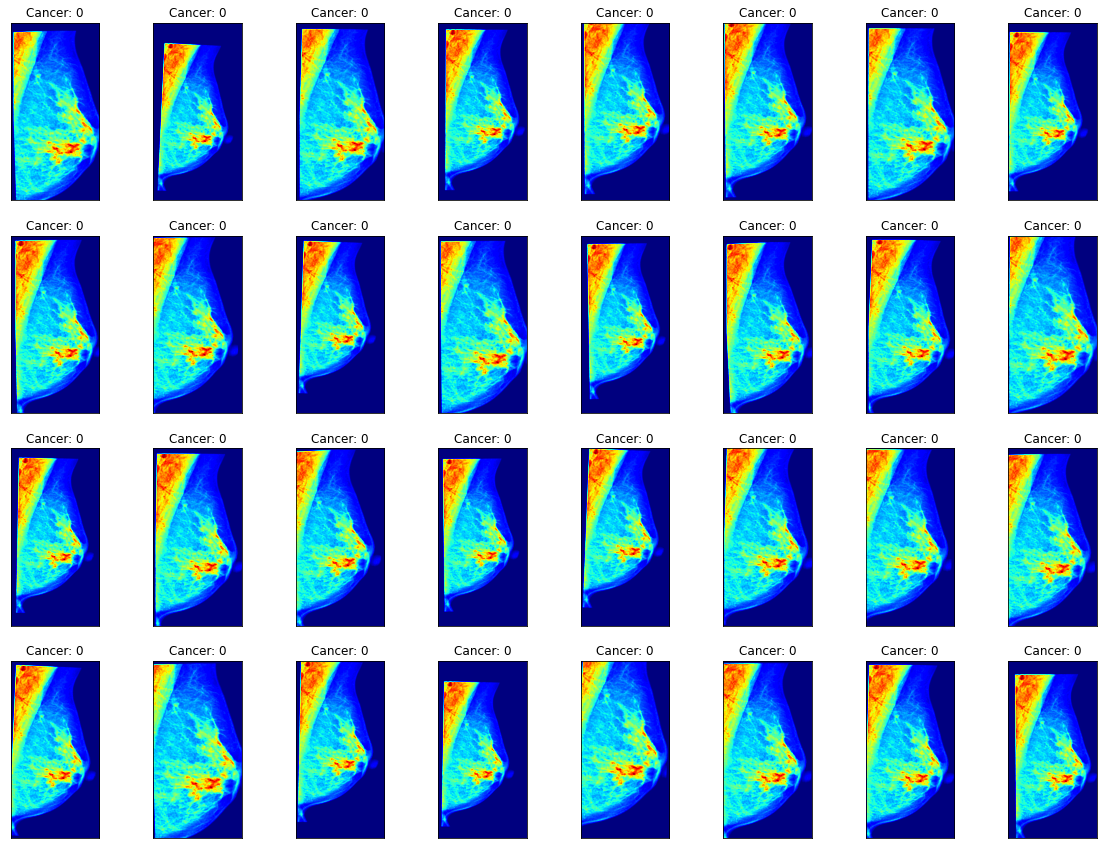

In [372]:
display_batch(constant_batch)

## First batch of the train dataset, with shuffle and augmentation

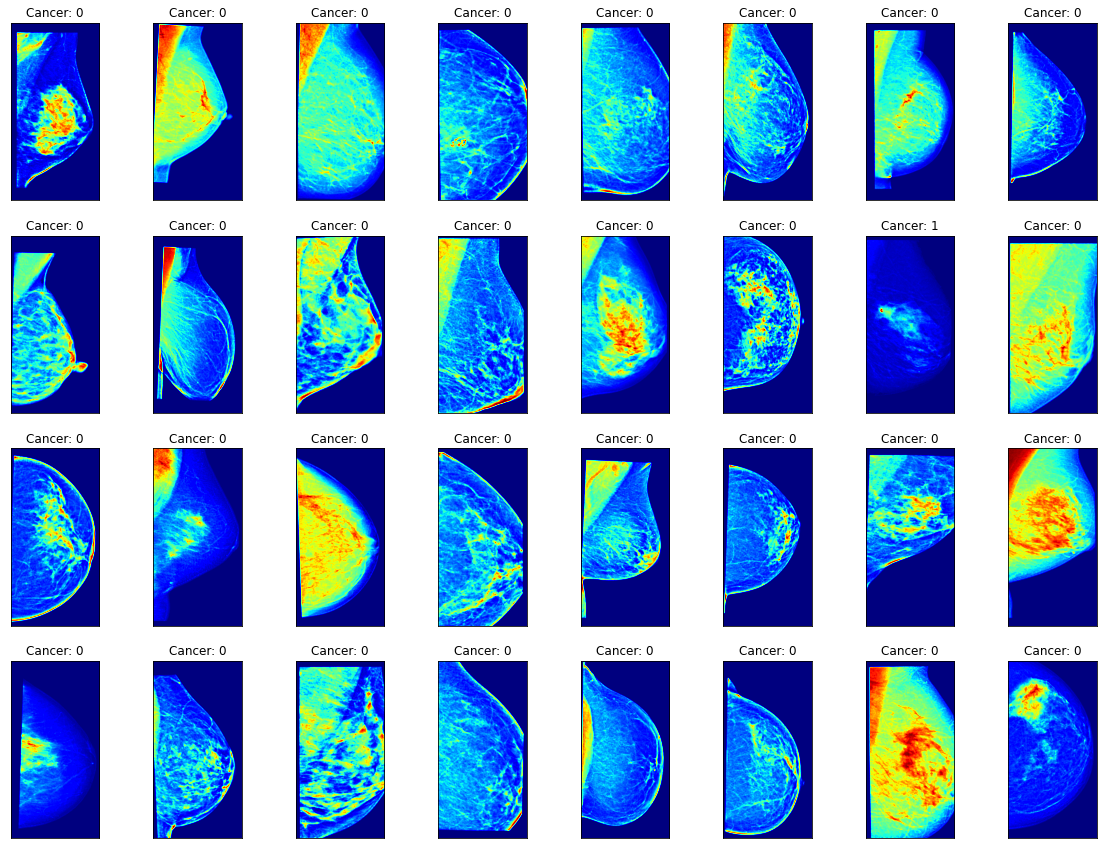

In [375]:
display_batch(train_batch)

# Competition Metric

The evaluation metric used in this competition is the **probabilistic F1 score (pF1)**, which is a variation of the traditional F1 score that takes into account the probabilities of predictions rather than binary classifications.

Additionally, the pF1 score also includes a version that allows for a greater emphasis on precision over recall by adjusting the beta parameter. The general formula for this version is as follows:

$$ pF_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{(\beta^2 \cdot precision) + recall} $$
Where,
$$ precision = \frac{pTP}{pTP + pFP} \hspace{1cm} recall = \frac{pTP}{TP + FN} $$

**Note:**

When the beta parameter is set to a value less than 1, the model is rewarded for having a higher recall even if the precision is lower. On the other hand, when the beta parameter is greater than 1, the model is rewarded for having a higher precision even if the recall is lower. In this competition, the beta parameter is set to 1, which results in the probabilistic F1 score (pF1) which gives equal importance to precision and recall. The model will be rewarded for achieving a balance between the two.

In [226]:
# https://www.kaggle.com/code/awsaf49/rsna-bcd-efficientnet-tf-tpu-1vm-train
# https://www.kaggle.com/code/markwijkhuizen/rsna-efficientnetv2-training-tensorflow-tpu/notebook

class pFBeta(tf.keras.metrics.Metric):
    def __init__(self, beta=1, name='pF1', **kwargs):
        super().__init__(name=name, **kwargs)
        self.beta = beta
        self.epsilon = 1e-10
        self.pos = self.add_weight(name='pos', initializer='zeros') # positive count
        self.ctp = self.add_weight(name='ctp', initializer='zeros') # true positive (sum of proba)
        self.cfp = self.add_weight(name='cfp', initializer='zeros') # false positive (sum of proba)
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.clip_by_value(y_pred, 0, 1)
        pos = tf.cast(tf.reduce_sum(y_true), tf.float32)
        ctp = tf.cast(tf.reduce_sum(y_pred[y_true == 1]), tf.float32)
        cfp = tf.cast(tf.reduce_sum(y_pred[y_true == 0]), tf.float32)
        self.pos.assign_add(pos)
        self.ctp.assign_add(ctp)
        self.cfp.assign_add(cfp)
        
    def result(self):
        beta2 = self.beta * self.beta
        prec = self.ctp / (self.ctp + self.cfp + self.epsilon)
        reca = self.ctp / (self.pos + self.epsilon)
        return (1 + beta2) * prec * reca / (beta2 * prec + reca)
        
    def reset_state(self):
        self.pos.assign(0.)
        self.ctp.assign(0.)
        self.cfp.assign(0.)

In [227]:
metrics = [pFBeta(),
            tfa.metrics.F1Score(num_classes=1, threshold=0.50),
            tf.keras.metrics.Precision(),
            tf.keras.metrics.Recall(),
            tf.keras.metrics.AUC(),
            tf.keras.metrics.BinaryAccuracy()]

# Build Model

In [ ]:
#wip